# Import required libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, plot_confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.naive_bayes import GaussianNB, MultinomialNB

# Read csv data

In [ ]:
data = pd.read_csv('EvenGroup_Dataset.csv')
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Data cleaning

## Handling missing values

In [ ]:
# Check for data type and missing values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


We can observe that the non-null count value is not consistent accross the features, thus we further check for the total of missing values for each features.

In [ ]:
data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Three features are found to contain missing values, which are Age, Cabin and Embarked. Since the number of missing values is quite different for these three features, we need to treat them differently.

 




**Age** - Age attribute might be useful in the final prediction stage and the total number of missing values is still under acceptable range. Thus, we can visualize the distribution of the data to determine which null values imputation method to be used.

(array([ 54.,  46., 177., 169., 118.,  70.,  45.,  24.,   9.,   2.]),
 array([ 0.42 ,  8.378, 16.336, 24.294, 32.252, 40.21 , 48.168, 56.126,
        64.084, 72.042, 80.   ]),
 <a list of 10 Patch objects>)

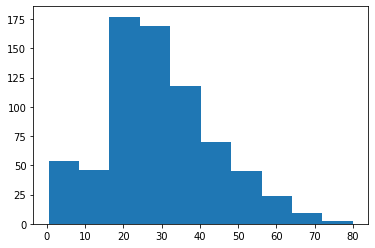

In [ ]:
# Visualize the distribution of Age to see which null values imputation to be used
plt.hist(data['Age'])

Since the distribution of the Age data seems to have a uniform structure and does not contains any outliers, then we can impute the missing values by using mean of the data.

In [ ]:
age_mean = data['Age'].mean()
print('Mean of Age: ', age_mean)
data['Age'].fillna(value=age_mean,inplace=True)

Mean of Age:  29.69911764705882


**Cabin** - Cabin attribute have a very high proportion of missing values, and simply impute the missing values might result in data that could not truly reflect the original data. Thus, one possible approach is to remove the column from the subsequent steps.

In [ ]:
data = data.drop(['Cabin'],axis=1)
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


**Embarked** - Similar to Age attribute, we can visualize the Embarked attribute to determine which imputation method to be used

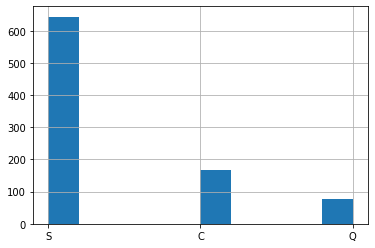

In [ ]:
# Visualize the distribution of Age to see which null values imputation to be used
data['Embarked'].hist()

Since Embarked attribute only have two samples of missing values, therefore there is a higher chance that the two missing values are fall under the mode class.

In [ ]:
# Fill null with mode category, which is S
data['Embarked'].fillna('S',inplace = True)
data.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

## Handling noise

Intuitively, PassengerId, Name and Ticket seems irrelavant towards the final prediction. Thus, they will be eliminated to avoid creating noise to the machine learning models.

In [ ]:
data = data.drop(['PassengerId','Name','Ticket'],axis=1)
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


## Handling inconsistent data

Since machine learning model is only able to consume numerical values as input, it is essential to convert the categorical features into numerical representation.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  891 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


We have two non-numerical attributes, thus we have to first convert them into numerical data type.

In [ ]:
data['Sex'].replace('male', 1 ,inplace=True)
data['Sex'].replace('female', 0,inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    int64  
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  891 non-null    object 
dtypes: float64(2), int64(5), object(1)
memory usage: 55.8+ KB


Embarked is belongs to nominal data category, thus simply replace the category with values might affect model performance. The model might have certain assumptions such as higher values contribute more towards certain target class. To avoid this issue, we will use one-hot encoding to represent the category in numerical format.

In [ ]:
# Get one hot encoding of columns Embarked
one_hot = pd.get_dummies(data['Embarked'],prefix='Embarked_')

# store the original embarked column for visualization purposes
embarked_temp = data.loc[:,['Survived','Embarked']]

# Drop column Embarked as it is now encoded
data = data.drop('Embarked',axis = 1)

# Join the encoded data
data = data.join(one_hot)
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked__C,Embarked__Q,Embarked__S
0,0,3,1,22.0,1,0,7.2500,0,0,1
1,1,1,0,38.0,1,0,71.2833,1,0,0
2,1,3,0,26.0,0,0,7.9250,0,0,1
3,1,1,0,35.0,1,0,53.1000,0,0,1
4,0,3,1,35.0,0,0,8.0500,0,0,1


Further checking if there are still any inconsistency in the data

In [ ]:
data.describe()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked__C,Embarked__Q,Embarked__S
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,0.647587,29.699118,0.523008,0.381594,32.204208,0.188552,0.086420,0.725028
std,0.486592,0.836071,0.477990,13.002015,1.102743,0.806057,49.693429,0.391372,0.281141,0.446751
min,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,22.000000,0.000000,0.000000,7.910400,0.000000,0.000000,0.000000
50%,0.000000,3.000000,1.000000,29.699118,0.000000,0.000000,14.454200,0.000000,0.000000,1.000000
75%,1.000000,3.000000,1.000000,35.000000,1.000000,0.000000,31.000000,0.000000,0.000000,1.000000
max,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,1.000000,1.000000,1.000000


We can observed that the range between the Q3 / 75th percentile and maximum value of Fare column is relatively high.

Text(0.5, 1.0, 'Boxplot of Fare')

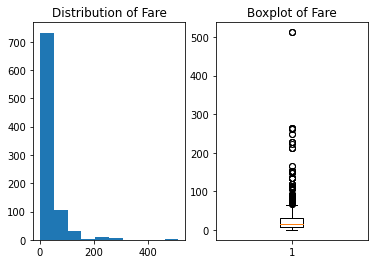

In [ ]:
figure, axis = plt.subplots(1, 2)
axis[0].hist(data['Fare'])
axis[0].set_title('Distribution of Fare')
axis[1].boxplot(data['Fare'])
axis[1].set_title('Boxplot of Fare')

From the plot above, we can observe that there are some outliers in the Fare attribute. Simply remove the outliers might not be a good option in this case, as the dataset is small and it might be useful towards the prediction outcome. Instead of representing the values of fare as it is, we could categorized the values into a certain range of values to avoid distorting the machine learning models during training.

In [ ]:
# We could use qcut function to cut the values into certain ranges instead
# The ideal category would be 6 from the histogram observation and we want to avoid most of the values falling into single category
pd.qcut(data['Fare'], q=6)

0        (-0.001, 7.775]
1      (52.369, 512.329]
2         (7.775, 8.662]
3      (52.369, 512.329]
4         (7.775, 8.662]
             ...        
886      (8.662, 14.454]
887       (26.0, 52.369]
888       (14.454, 26.0]
889       (26.0, 52.369]
890      (-0.001, 7.775]
Name: Fare, Length: 891, dtype: category
Categories (6, interval[float64, right]): [(-0.001, 7.775] < (7.775, 8.662] < (8.662, 14.454] <
                                           (14.454, 26.0] < (26.0, 52.369] < (52.369, 512.329]]

In [ ]:
data.loc[data['Fare'] <= 7, 'Fare'] = 0
data.loc[(data['Fare'] > 7) & (data['Fare'] <= 8), 'Fare'] = 1
data.loc[(data['Fare'] > 8) & (data['Fare'] <= 14), 'Fare']   = 2
data.loc[(data['Fare'] > 14) & (data['Fare'] <= 26), 'Fare']   = 3
data.loc[(data['Fare'] > 26) & (data['Fare'] <= 52), 'Fare']   = 4
data.loc[data['Fare'] > 52, 'Fare'] = 5
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked__C,Embarked__Q,Embarked__S
0,0,3,1,22.0,1,0,1.0,0,0,1
1,1,1,0,38.0,1,0,5.0,1,0,0
2,1,3,0,26.0,0,0,1.0,0,0,1
3,1,1,0,35.0,1,0,5.0,0,0,1
4,0,3,1,35.0,0,0,2.0,0,0,1


# Data visualization

Now, all the data has been cleaned. We could better analyze the data using various visualization.

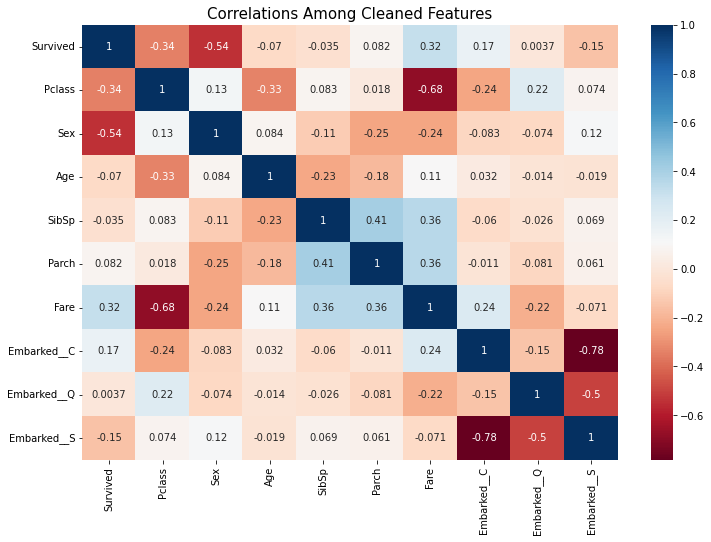

In [ ]:
# Heatmap visualization
plt.subplots(figsize = (12,8))
sns.heatmap(data.corr(), annot=True,cmap="RdBu")
plt.title("Correlations Among Cleaned Features", fontsize = 15);

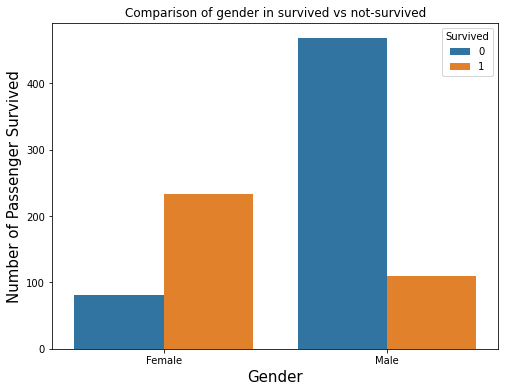

In [ ]:
plt.subplots(figsize = (8,6))
ax=sns.countplot(x='Sex', data = data, hue='Survived')

# Set title, xlabel and ylabel
plt.title('Comparison of gender in survived vs not-survived')
plt.xlabel('Gender', fontsize=15)
plt.ylabel("Number of Passenger Survived", fontsize = 15)
labels = ['Female', 'Male']

# Fixing xticks
plt.xticks(sorted(data.Survived.unique()),labels);

From barchart above, Female shows a higher survival as compared to male.

Text(0, 0.5, 'Number of Passenger Survived')

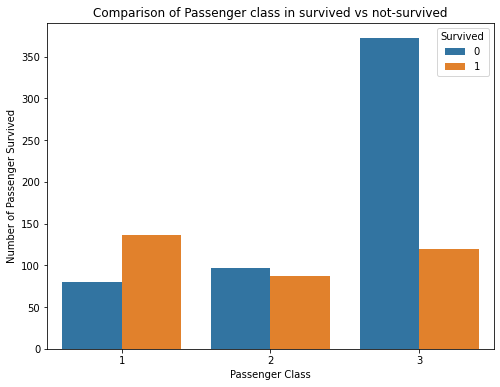

In [ ]:
plt.subplots(figsize = (8,6))
ax=sns.countplot(x='Pclass', data = data, hue='Survived')

# Set title, xlabel and ylabel
plt.title('Comparison of Passenger class in survived vs not-survived')
plt.xlabel('Passenger Class')
plt.ylabel("Number of Passenger Survived")


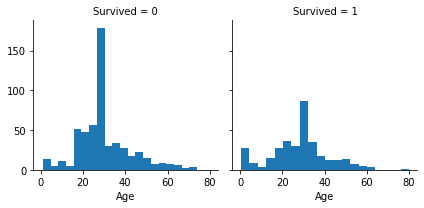

In [ ]:
g = sns.FacetGrid(data, col='Survived')
g.map(plt.hist, 'Age', bins=20)

Both the histogram plot above shows that the trend for survived and non-survived passenger for different Age group is quite similar, except that passenger within 25-35 has a very high non-survived rate as compared to survived rate.

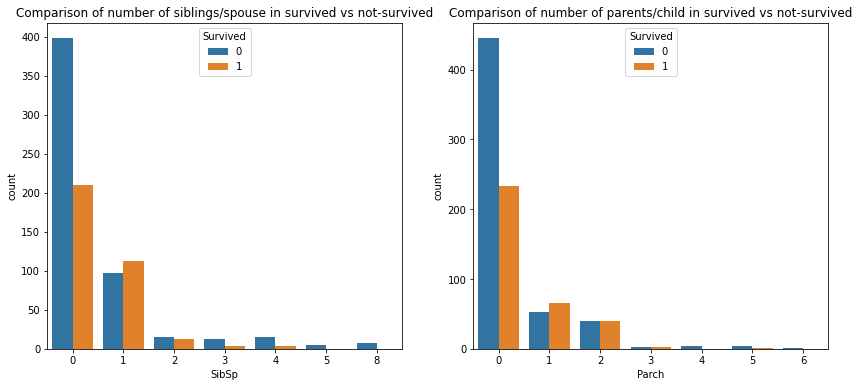

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
 
sns.countplot(ax=axes[0], data=data, x='SibSp', hue='Survived')
sns.countplot(ax=axes[1], data=data, x='Parch', hue='Survived')

axes[0].set_title('Comparison of number of siblings/spouse in survived vs not-survived')
axes[1].set_title('Comparison of number of parents/child in survived vs not-survived')

plt.legend(title='Survived',loc='upper center')

One observation from two plots above is that passenger with number of siblings/spouse or parents/children above 4 is less likely to survived.

Text(0, 0.5, 'Number of Passenger Survived')

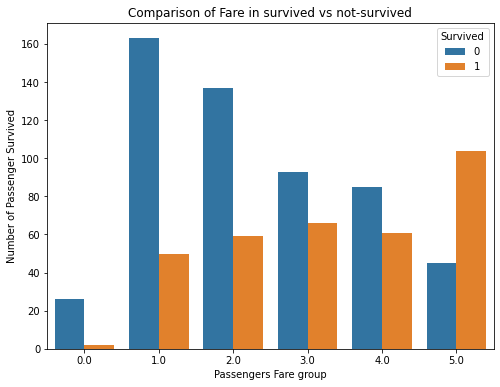

In [ ]:
plt.subplots(figsize = (8,6))
ax=sns.countplot(x='Fare', data = data, hue='Survived')

# Set title, xlabel and ylabel
plt.title('Comparison of Fare in survived vs not-survived')
plt.xlabel('Passengers Fare group')
plt.ylabel("Number of Passenger Survived")

The passengers that fall under the last fare category (5), which is fare range between 52 to 512 shows a higher survival rate.

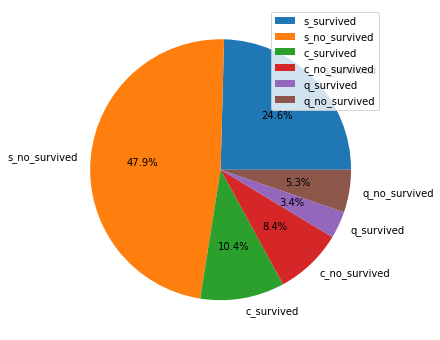

In [ ]:
total_embarked = embarked_temp.Survived.count()

s_class = embarked_temp[embarked_temp['Embarked'] == 'S']
s_survived = s_class[s_class['Survived'] == 1].Survived.count()/total_embarked
s_no_survived = s_class[s_class['Survived'] == 0].Survived.count()/total_embarked
c_class = embarked_temp[embarked_temp['Embarked'] == 'C']
c_survived = c_class[c_class['Survived'] == 1].Survived.count()/total_embarked
c_no_survived = c_class[c_class['Survived'] == 0].Survived.count()/total_embarked
q_class = embarked_temp[embarked_temp['Embarked'] == 'Q']
q_survived = q_class[q_class['Survived'] == 1].Survived.count()/total_embarked
q_no_survived = q_class[q_class['Survived'] == 0].Survived.count()/total_embarked

pct_embarked = [s_survived,s_no_survived,c_survived,c_no_survived,q_survived,q_no_survived]
pct_embarked_label = ['s_survived','s_no_survived','c_survived','c_no_survived','q_survived','q_no_survived']

plt.subplots(figsize = (8,6))
plt.pie(pct_embarked, labels = pct_embarked_label,autopct='%1.1f%%')
plt.legend(loc='upper right')
plt.show() 


The pie chart above show that majority of Passenger that going to embarked at S have the highest non-survived rate as compared to others. 

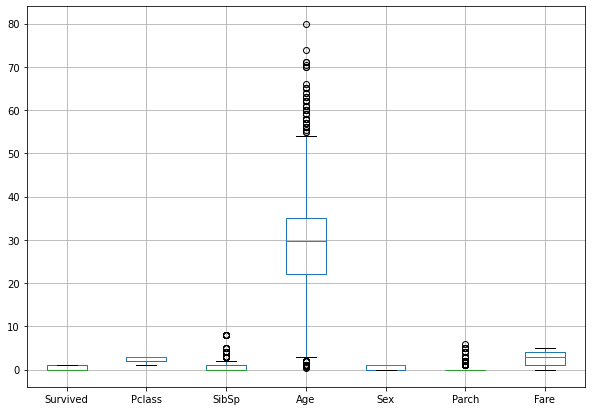

In [ ]:
plt.figure(figsize =(10, 7))
data.boxplot(['Survived','Pclass','SibSp','Age','Sex','Parch','Fare'])


We can observed that three attributes which are SibSp, Age and Parch might have some outliers presence in the data. The next step might be further investigate whether the distribution of these three attributes have anomaly behaviour that migh affect the machine learning model during training.

Text(0.5, 1.0, 'Distribution of number of parents/children')

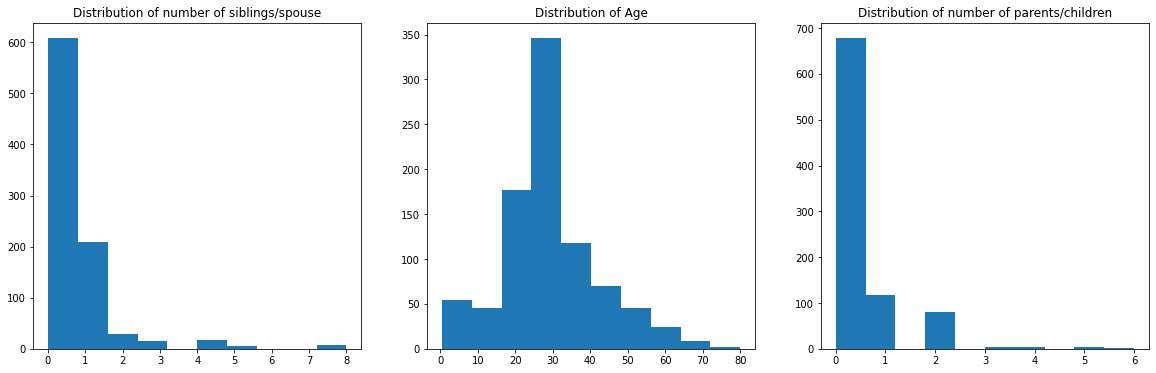

In [ ]:
figure, axis = plt.subplots(1, 3,figsize=(20,6))

axis[0].hist(data['SibSp'])
axis[0].set_title('Distribution of number of siblings/spouse')
axis[1].hist(data['Age'])
axis[1].set_title('Distribution of Age')
axis[2].hist(data['Parch'])
axis[2].set_title('Distribution of number of parents/children')

The distribution of Age seems to exhibit a uniform distribution, whereas the distribution of SibSp and Parch might seems to contains certain outliers. Consider that the size of the data is small and chances of a passengers have more than 3 siblings/spouses or parents/children aboard is very likely to occur in real world scenario, we might want to preserve the data as it is.

Text(0.5, 0.98, 'Count of survival')

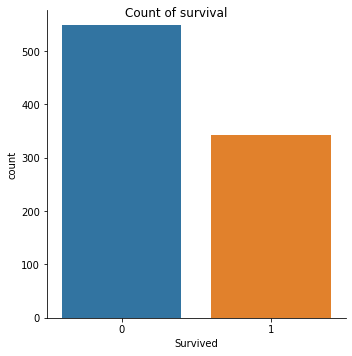

In [ ]:
p = sns.catplot(x="Survived", 
                data=data, kind="count")
p.fig.suptitle('Count of survival')


The number of non-survival in the dataset seems to be higher than the number of survival, we should take note of it

# Data Modeling

Split data into training and testing set

In [ ]:
X = data.drop(['Survived'],axis=1)
y = data['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Since the dataset is small, we might want to use cross validation to get a true performance of model on the dataset. Also, most of the machine learning models are having a numbers of hyperparameter that might have different effect towards the model performance. Hence, we choose to use a very popular approach, which is grid search with cross validation for finding the best hyperparameters for a model.

### SVM

SVM with default hyperparameters without any tuning

In [ ]:
model_svm = SVC()

model_svm.fit(X_train, y_train)

y_test_hat=model_svm.predict(X_test) 

test_accuracy=accuracy_score(y_test,y_test_hat)*100

print("Accuracy for test set without tuning is : {:.2f}%".format(test_accuracy) )

Accuracy for test set without tuning is : 60.34%


Applied grid search with cross validation to find the best hyperparameters

In [ ]:
svm_model = SVC()

# defining parameter range
param_grid = {'C':[1,10,100,1000],'gamma':[1,0.1,0.001,0.0001], 'kernel':['linear','rbf']}
  

grid = GridSearchCV(svm_model,param_grid,refit = True, verbose=3)
  
# fitting the model for grid search
grid_search=grid.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV 1/5] END .......C=1, gamma=1, kernel=linear;, score=0.797 total time=   0.3s
[CV 2/5] END .......C=1, gamma=1, kernel=linear;, score=0.804 total time=   0.2s
[CV 3/5] END .......C=1, gamma=1, kernel=linear;, score=0.754 total time=   0.0s
[CV 4/5] END .......C=1, gamma=1, kernel=linear;, score=0.754 total time=   1.8s
[CV 5/5] END .......C=1, gamma=1, kernel=linear;, score=0.824 total time=   1.0s
[CV 1/5] END ..........C=1, gamma=1, kernel=rbf;, score=0.734 total time=   0.0s
[CV 2/5] END ..........C=1, gamma=1, kernel=rbf;, score=0.741 total time=   0.0s
[CV 3/5] END ..........C=1, gamma=1, kernel=rbf;, score=0.739 total time=   0.0s
[CV 4/5] END ..........C=1, gamma=1, kernel=rbf;, score=0.746 total time=   0.0s
[CV 5/5] END ..........C=1, gamma=1, kernel=rbf;, score=0.754 total time=   0.0s
[CV 1/5] END .....C=1, gamma=0.1, kernel=linear;, score=0.797 total time=   0.3s
[CV 2/5] END .....C=1, gamma=0.1, kernel=linear

In [ ]:
# Show the best parameter for SVM
print(grid_search.best_params_)

{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}


In [ ]:
model_svm = SVC(C=1000,gamma=0.001,kernel='rbf')

model_svm.fit(X_train, y_train)

y_test_hat=model_svm.predict(X_test) 

test_accuracy=accuracy_score(y_test,y_test_hat)*100

print("Accuracy for test set with tuning is : {:.2f}%".format(test_accuracy) )


Accuracy for test set with tuning is : 80.45%


In [ ]:
print(classification_report(y_test, y_test_hat))

              precision    recall  f1-score   support

           0       0.82      0.86      0.84       105
           1       0.78      0.73      0.76        74

    accuracy                           0.80       179
   macro avg       0.80      0.79      0.80       179
weighted avg       0.80      0.80      0.80       179



In [ ]:
# Confusion matrix
cm_svm = confusion_matrix(y_test, y_test_hat)
cm_svm

array([[90, 15],
       [20, 54]])

Text(33.0, 0.5, 'Actual')

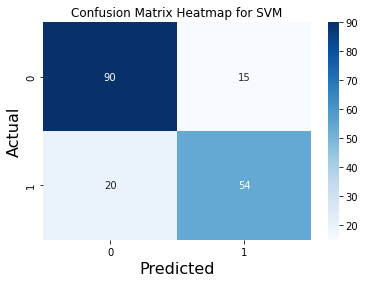

In [ ]:
# Plot confusion matrix heatmap
sns_plot = sns.heatmap(cm_svm, annot=True, cmap='Blues')
sns_plot.set_title('Confusion Matrix Heatmap for SVM')
plt.xlabel("Predicted", size=16)
plt.ylabel("Actual", size=16)

### Naive Bayes

Naive bayes without hypeparameter tuning

In [ ]:
nb_classifier = GaussianNB()

nb_classifier.fit(X_train, y_train)

y_test_hat=nb_classifier.predict(X_test) 

test_accuracy=accuracy_score(y_test,y_test_hat)*100

print("Accuracy for test set without tuning is : {:.2f}%".format(test_accuracy) )


Accuracy for test set without tuning is : 75.98%


Grid search with cross validation to find the best hyperparameters

In [ ]:
# Gaussian Naive Bayes

nb_classifier = GaussianNB()

params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}
gs_NB = GridSearchCV(nb_classifier,params_NB,refit = True, verbose=3) 
gs_NB.fit(X_train, y_train)

gs_NB.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END .................var_smoothing=1.0;, score=0.622 total time=   0.0s
[CV 2/5] END .................var_smoothing=1.0;, score=0.622 total time=   0.0s
[CV 3/5] END .................var_smoothing=1.0;, score=0.627 total time=   0.0s
[CV 4/5] END .................var_smoothing=1.0;, score=0.627 total time=   0.0s
[CV 5/5] END .................var_smoothing=1.0;, score=0.620 total time=   0.0s
[CV 1/5] END ..var_smoothing=0.8111308307896871;, score=0.622 total time=   0.0s
[CV 2/5] END ..var_smoothing=0.8111308307896871;, score=0.622 total time=   0.0s
[CV 3/5] END ..var_smoothing=0.8111308307896871;, score=0.627 total time=   0.0s
[CV 4/5] END ..var_smoothing=0.8111308307896871;, score=0.627 total time=   0.0s
[CV 5/5] END ..var_smoothing=0.8111308307896871;, score=0.620 total time=   0.0s
[CV 1/5] END ...var_smoothing=0.657933224657568;, score=0.622 total time=   0.0s
[CV 2/5] END ...var_smoothing=0.65793322465756

{'var_smoothing': 0.0004328761281083057}

In [ ]:
nb_classifier = GaussianNB(var_smoothing=0.00043)

nb_classifier.fit(X_train, y_train)

y_test_hat=nb_classifier.predict(X_test) 

test_accuracy=accuracy_score(y_test,y_test_hat)*100

print("Accuracy for test set with tuning is : {:.2f}%".format(test_accuracy) )


Accuracy for test set with tuning is : 79.33%


In [ ]:
print(classification_report(y_test, y_test_hat))

              precision    recall  f1-score   support

           0       0.88      0.75      0.81       105
           1       0.71      0.85      0.77        74

    accuracy                           0.79       179
   macro avg       0.79      0.80      0.79       179
weighted avg       0.81      0.79      0.79       179



In [ ]:
# Confusion matrix
cm_nb = confusion_matrix(y_test, y_test_hat)
cm_nb

array([[79, 26],
       [11, 63]])

Text(33.0, 0.5, 'Actual')

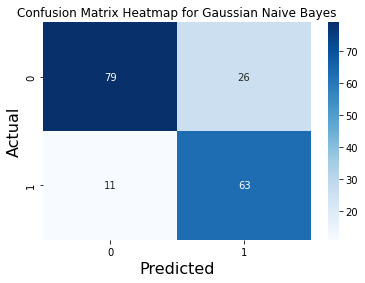

In [ ]:
# Plot confusion matrix heatmap
sns_plot = sns.heatmap(cm_nb, annot=True, cmap='Blues')
sns_plot.set_title('Confusion Matrix Heatmap for Gaussian Naive Bayes')
plt.xlabel("Predicted", size=16)
plt.ylabel("Actual", size=16)